## Cluster-Mass based Permutation testing in Julia

- Step 1: load and check adjacency matrix
- Step 2: generate simuated data
- Step 3: run cluster-mass permutation test

### Load Libraries

In [3]:
import Pkg
Pkg.activate("..")
Pkg.add("MAT")

using UnfoldSim
using MAT 
using CairoMakie

include("../read_adjacency.jl")


  Activating new project at `/data/tu_grossmannr/PhDProject_Experimental/ClusterComputation`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed StringEncodings ─ v0.3.7
   Installed MAT ───────────── v0.11.4
    Updating `/data/tu_grossmannr/PhDProject_Experimental/ClusterComputation/Project.toml`
  [23992714] + MAT v0.11.4
    Updating `/data/tu_grossmannr/PhDProject_Experimental/ClusterComputation/Manifest.toml`
  [944b1d66] + CodecZlib v0.7.8
  [34da2185] + Compat v4.18.1
  [9a962f9c] + DataAPI v1.16.0
  [e2d170a0] + DataValueInterfaces v1.0.0
  [f67ccb44] + HDF5 v0.17.2
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [692b3bcd] + JLLWrappers v1.7.1
  [23992714] + MAT v0.11.4
  [3da0fdf6] + MPIPreferences v0.1.11
  [bac558e1] + OrderedCollections v1.8.1
  [2dfb63ee] + PooledArrays v1.4.3
  [21216c6a] + Preferences v1.5.1
  [ae029012] + Requires v1.3.1
  [69024149] + StringEncodings v0.3.7
  [3783bdb8] + TableTraits v1.0.1
  

read_fieldtrip_neighbors

In [4]:
# load Hartmut head model
# needed for visualization of adjacency and simulation of effects
hart = Hartmut()

#Define 10-20 channels (these fit to the biosemi neighbours file we later use)
standard_1020 = ["Fp1", "AF3", "F7", "F3", "FC1", "FC5", "T7", "C3", "CP1", "CP5", "P7", "P3", "Pz", "PO3", "O1", "Oz", "O2", "PO4", "P4", "P8", "CP6", "CP2", "C4", "T8", "FC6", "FC2", "F4", "F8", "AF4", "Fp2", "Fz", "Cz"]


Please cite: HArtMuT: Harmening Nils, Klug Marius, Gramann Klaus and Miklody Daniel - 10.1088/1741-2552/aca8ce


32-element Vector{String}:
 "Fp1"
 "AF3"
 "F7"
 "F3"
 "FC1"
 "FC5"
 "T7"
 "C3"
 "CP1"
 "CP5"
 ⋮
 "T8"
 "FC6"
 "FC2"
 "F4"
 "F8"
 "AF4"
 "Fp2"
 "Fz"
 "Cz"

In [6]:
# Load FieldTrip neighbor file and reorder to match our channel layout - note that adjacency matrix might need to be created based on the individual set of channels (using MNE/Fieldtrip)
ft_neighbor_path = "biosemi32_neighb.mat"

adjacency, matched_labels = read_fieldtrip_neighbors(
    ft_neighbor_path; 
    channel_order = standard_1020  # Reorder to match layout (should not matter in this example, since we use all channels)
)


(Bool[0 1 … 0 0; 1 0 … 1 0; … ; 0 1 … 0 1; 0 0 … 1 0], ["Fp1", "AF3", "F7", "F3", "FC1", "FC5", "T7", "C3", "CP1", "CP5"  …  "C4", "T8", "FC6", "FC2", "F4", "F8", "AF4", "Fp2", "Fz", "Cz"])

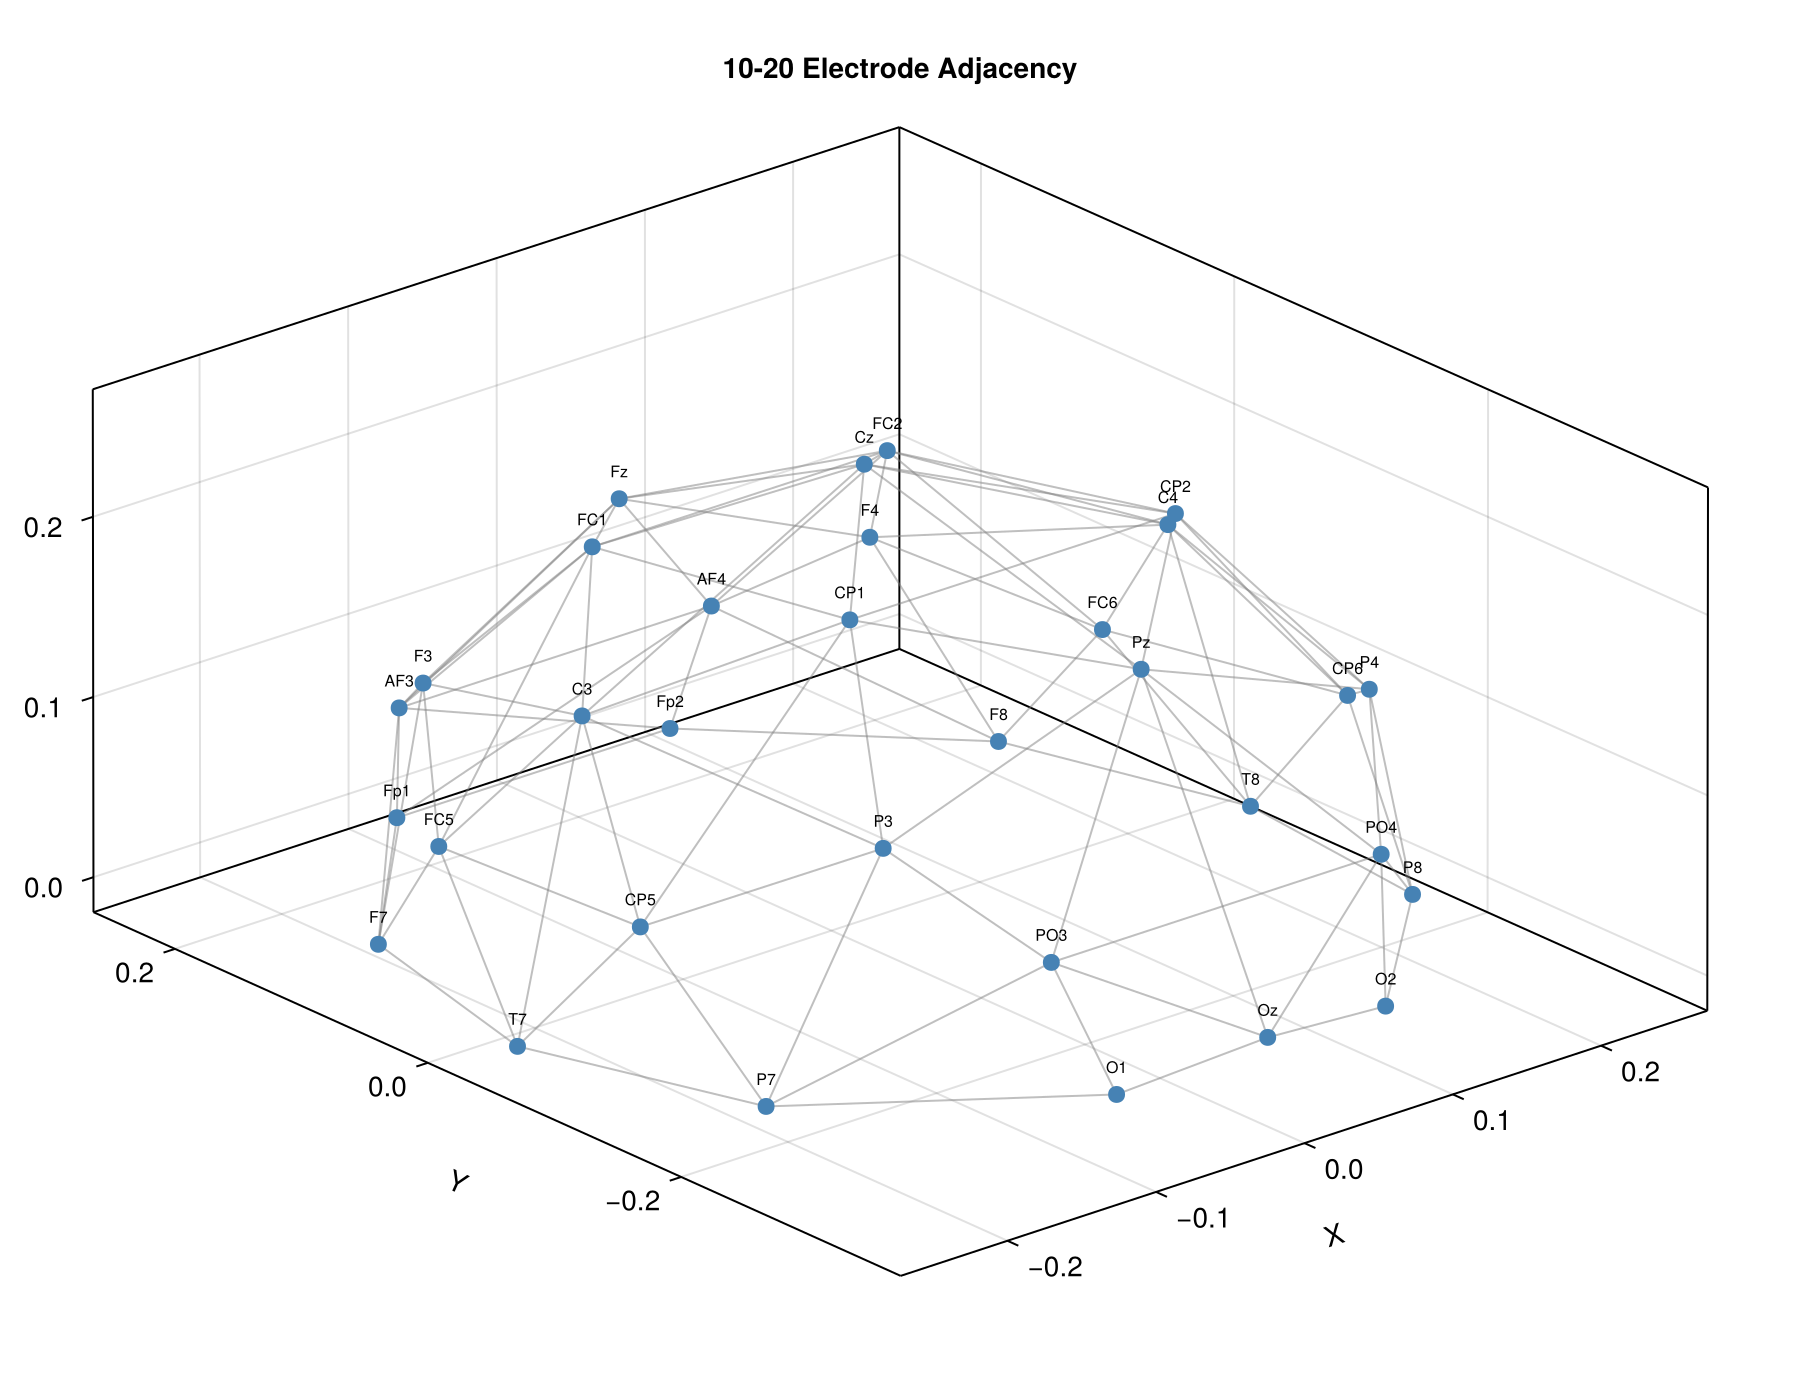

In [7]:
# Visualize the adjacency

# Find indices of channels in HArtMuT
all_labels = hart.electrodes["label"]
channel_idx_raw = [findfirst(==(ch), all_labels) for ch in standard_1020]

# Filter out channels not found in HArtMuT and get their labels
found_mask = .!isnothing.(channel_idx_raw)
channel_idx = Int64[idx for idx in channel_idx_raw if !isnothing(idx)]
electrode_labels = standard_1020[found_mask]

# Extract subset of electrode positions
electrode_positions = hart.electrodes["pos"][channel_idx, :]

fig = Figure(size = (900, 700))
ax = Axis3(fig[1, 1], 
    title = "10-20 Electrode Adjacency",
    xlabel = "X", ylabel = "Y", zlabel = "Z",
    aspect = :data)

pos3d = electrode_positions

# Draw connections between adjacent electrodes
for i in 1:size(adjacency, 1)
    for j in (i+1):size(adjacency, 2)
        if adjacency[i, j]
            lines!(ax, 
                [pos3d[i, 1], pos3d[j, 1]], 
                [pos3d[i, 2], pos3d[j, 2]], 
                [pos3d[i, 3], pos3d[j, 3]],
                color = (:gray, 0.5), linewidth = 1.0)
        end
    end
end

# Draw electrode points with labels
scatter!(ax, pos3d[:, 1], pos3d[:, 2], pos3d[:, 3], 
    markersize = 12, color = :steelblue)

# Add electrode labels
for (i, label) in enumerate(electrode_labels)
    text!(ax, pos3d[i, 1], pos3d[i, 2], pos3d[i, 3] + 0.01, 
        text = label, fontsize = 8, align = (:center, :bottom))
end

fig